# Цель проекта
### Цель проекта — закрепить понимание принципов работы алгоритмов деревьев решений, ансамблей и кластеризации через собственную реализацию и анализ их поведения на данных.

В ходе проекта вы:

1. реализуете базовые версии алгоритмов с нуля, используя numpy и pandas;
2. проведёте эксперименты с параметрами и сравните результаты с реализациями из sklearn;
3. научитесь интерпретировать результаты и визуализировать их.

## Этап 1. Реализация дерева решений (15 баллов)
На этом этапе вы создаёте простую реализацию дерева решений для задачи классификации.

#### Что нужно сделать
1. Сгенерируйте небольшой набор данных (100–300 наблюдений).
2. Преобразуйте данные в pandas.DataFrame.

3. Реализуйте функции:

$\hspace{0.6cm}$ 3.1. расчёта критерия Джини или энтропии;

$\hspace{0.6cm}$ 3.2. поиска наилучшего разбиения по признаку;

$\hspace{0.6cm}$ 3.3. рекурсивного построения дерева с ограничением по глубине (max_depth) или по числу объектов в узле (min_samples_split);

$\hspace{0.6cm}$ 3.4. предсказания для новых наблюдений.
#### Тестирование модели
1. Разделите данные на обучающую и тестовую выборки (например, с помощью train_test_split, зафиксировав random_state=42 для воспроизводимости).

2. Сравните результаты своей реализации с DecisionTreeClassifier из sklearn. Разрешается использовать этот класс только для сверки корректности.

3. Постройте график границ решений (если данных 2D) с помощью matplotlib.
#### Результат
1. Таблица с точностью (accuracy) на обучении и тесте.

2. Визуализация дерева или границ решений.

3. Краткий комментарий о различиях вашей реализации и sklearn.

#### Решение
1. Генерируем набор данных в соответсвии с заданием

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=200,
    n_features=2,  # два признака для наглядной визуализации границ решений
    n_informative=2,
    n_redundant=0,
    random_state=42
)

2. Преобразуем данные в датафрейм

In [177]:
trees_task_data = pd.DataFrame({
    'feature_1' : X[:,0],
    'feature_2' : X[:,1], 
    'label' : y
})

In [178]:
trees_task_data.head()

,feature_1,feature_2,label
0,1.689767,-1.408241,1
1,1.530287,-1.459848,1
2,-1.175042,-1.447633,0
3,-2.585395,0.963532,0
4,1.372246,0.440695,1


3. Реализуем функции

$\hspace{0.6cm}$ 3.1. Функция расчета энтропии

In [179]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

$\hspace{0.6cm}$ 3.2. Функция поиска наилучшего разбиения по признаку 

$\hspace{1cm}$ 3.2.1. Функция определения кандидатов в параметры предиката

In [180]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

$\hspace{1cm}$ 3.2.2. Функция разбиения выборки по предикату на левую и правую части

In [181]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

$\hspace{1cm}$ 3.2.3. Функция расчета взвешенной неоднородности после разбиения

In [182]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

$\hspace{1cm}$ 3.2.4. Функция поиска наилучшего разбиения по признаку

In [183]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

3.3. Функция рекурсивного построения дерева с ограничением по глубине.

$\hspace{0.6cm}$ 3.3.1. Класс вершины

$\hspace{0.6cm}$ Атрибуты класса:

$\hspace{0.6cm}$ left — ссылка на левого потомка;

$\hspace{0.6cm}$ right — ссылка на правого потомка;

$\hspace{0.6cm}$ value — ответ алгоритма;

$\hspace{0.6cm}$ split_params — параметры разбиения (сплита);

$\hspace{0.6cm}$ impurity — неоднородность в вершине (пригодится для расчёта важности признаков);

$\hspace{0.6cm}$ samples — количество объектов, попавших в вершину;

$\hspace{0.6cm}$ is_leaf — булева переменная, которая указывает, является ли вершина листовой.

In [184]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

$\hspace{1cm}$ 3.3.2. Функция расчета самого популярного класса

In [185]:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

$\hspace{1cm}$ 3.3.3. Функция расчета критерия остановки

In [186]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)

$\hspace{0.6cm}$ 3.3.4. Функция рекурсивного построения дерева решений с ограничением по глубине дерева

In [187]:
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_right, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

3.4. Функция предсказания для новых наблюдений

$\hspace{0.6cm}$ 3.4.1. Функция предсказания для одного наблюдения

In [188]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

$\hspace{0.6cm}$ 3.4.2. Функция предсказания для всех объектов выборки.

In [189]:
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

4. Тестирование модели

$\hspace{0.6cm}$ 4.1. Разделение данных на обучающую и тестовую выборки

In [190]:
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(trees_task_data[['feature_1','feature_2']], trees_task_data['label'], test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (160, 2)
Test shape: (40, 2)


$\hspace{0.6cm}$ 4.2. Построение дерева решений на обучающей выборке с помощью написанных функций

In [191]:
decision_tree = build_decision_tree(X_train, y_train, criterion=entropy)

$\hspace{0.6cm}$ 4.3. Предсказание целевой переменной и проверка точности на обучающей и тестовой выборке 

In [192]:
y_train_pred = predict(decision_tree, X_train)

y_test_pred = predict(decision_tree, X_test)

print('Training accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Training accuracy: 1.000
Test accuracy: 0.875


$\hspace{0.6cm}$ 4.4. Построение графика границ решений для дерева, построенного по написанным функциям

In [193]:
# Функция визуализации границ решений 
def plot_decision_bound_regression_manual(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    X_net = pd.DataFrame(X_net)
    y_pred = predict(decision_tree, X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)


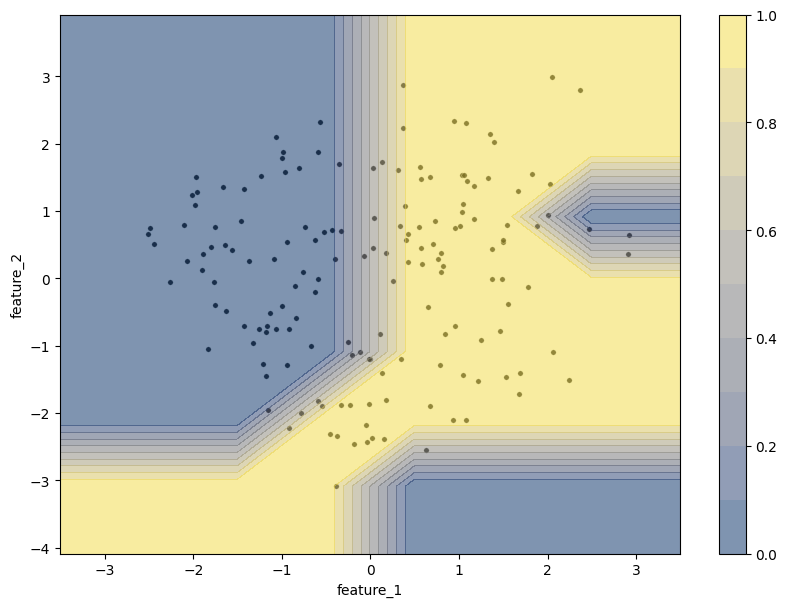

In [194]:

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression_manual(X_train, y_train, decision_tree, fig)

$\hspace{0.6cm}$ 4.5. Построение дерева решений с помощью DecisionTreeClassifier из sklearn

In [195]:
# Инициализируем модель дерева решений и обучаем ее
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)


,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


$\hspace{0.6cm}$ 4.6. Предсказание целевой переменной и проверка точности на тестовой выборке деревом решений из DecisionTreeClassifier из sklearn

In [196]:

y_train_pred = dt.predict(X_train)

y_test_pred = dt.predict(X_test)

print('Training accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Training accuracy: 1.000
Test accuracy: 0.850


$\hspace{0.6cm}$ 4.7. Построение графика границ решений

c:\Users\troyd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


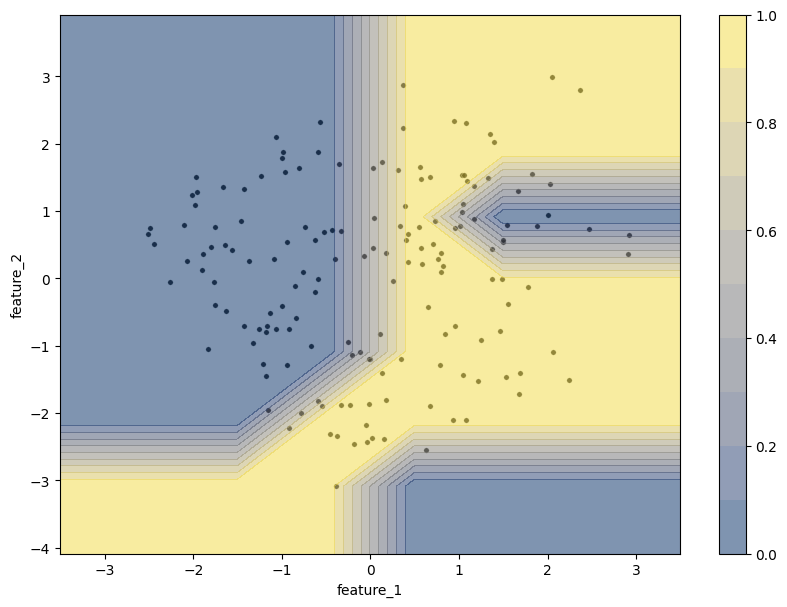

In [197]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X_train, y_train, dt, fig)

## 5. Результат

 5.1. Таблица с точностью (accuracy) на обучении и тесте при построении дерева "вручную".
$$
\begin{array}{|c|c|}
\hline \text{Training accuracy} & 1.000 \\
\hline \text{Test accuracy} & 0.875 \\
\hline
\end{array}
$$

 5.2. Таблица с точностью (accuracy) на обучении и тесте при построении дерева с помощью sklearn.
$$
\begin{array}{|c|c|}
\hline \text{Training accuracy} & 1.000 \\
\hline \text{Test accuracy} & 0.850 \\
\hline
\end{array}
$$

 5.3. Визуализация границ решений.

 Визуализация границ решений представлена в пунктах 4.4. и 4.7. (см. выше).

 5.4. Краткий комментарий о различиях вашей реализации и sklearn.

 В рамках выполнения задания были построены две модели дерева решений. Первая модель реализована "вручную", вторая с помощью библиотеки sklearn. Реализация с помощью готовой 
 библиотеки более быстрая и удобная, однако при реализации "вручную" становится возможно заглянуть внутрь процесса построения дерева решений и понять необходимые шаги. Обе модели  одинаково точно описывают значения обучающей (Training) выборки, что видно из таблиц в п. 5.1. и п. 5.2. Небольшие расхождения в точности наблюдаются при проверке моделей на  тестовой (Test) выборке: 87.5 % для дерева, построенного "вручную", 85 % для дерева, построенного с помощью sklearn. Разница незначительна и может быть связана с отличиями 
 алгоритмов построения моделей.

